# クラス分類学習モデルの作成、予測の実行

In [1]:
import os
import random

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# 特徴量選択
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    VarianceThreshold,
    RFE,
    RFECV,
)
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/Users/masanari/Library/CloudStorage/OneDrive-東京理科大学/projects/breast_cancer_analytics/notebooks/functions.py:242: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


# 2値分類モデルの作成・実行

2値分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
決定木以外にも、基本的な2値分類を実施できるモデルを採用し、各モデル間で比較していく。  
精度は重視しないが、accuracyよりもf1スコアを重視する。  
目的変数に偏りがある（不均衡データ、1（5年後以内に死亡）<0（5年語以内に生存））ので、**サンプリング方法を要検討**

In [2]:
X = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X.pkl")
y = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y.pkl")


# 説明変数のdf
X_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_train.pkl"
)
X_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_test.pkl"
)
"""

X_train_std = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_train_std.pkl"
)
X_test_std = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_test_std.pkl"
)
X_train_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_train_norm.pkl"
)
X_test_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_test_norm.pkl"
)
"""

# 目的変数のpd.Series
y_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y_train.pkl"
)
y_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y_test.pkl"
)

In [3]:
X_train.shape, X_test.shape

((1187, 53), (396, 53))

# 学習データの分布をプロット

オーバーサンプリング手法がどのように目的変数を生成しているのかを可視化する。  
x,y軸には以下の２パターンを描画する  
1. 3.0.0のノートブックで実施した決定木で重要度の上位に位置した特徴量（["NPI", "THREEGENE_ER-/HER2-"]）
2. float型の特徴量の中で、値がそれなりに分布している特徴量（["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]）

## ツール
- seaborn-analyzer: https://github.com/c60evaporator/seaborn-analyzer

### 可視化関数

In [4]:
# 散布図のプロット。targetの分類や、plot_columnsに沿った分布の様子も表記
def sns_join_plot(
    X: pd.DataFrame(),  # 2次元のdf。縦軸・横軸に表示したい特徴量を持つ
    y: pd.Series(),  # 目的変数。色分けして表示する。
    plot_columns: list,
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    if normalization:
        df_tmp = transform_norm(X[plot_columns])
    else:
        df_tmp = X[plot_columns]
    sns.jointplot(
        data=df_tmp,
        x=plot_columns[0],
        y=plot_columns[1],
        hue=y,
        palette="colorblind",
    )
    plt.plot()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


"""
        
# モデルとその分類結果のプロットを実施（表示する都合上、2次元なため、あくまでなんとなくの分類境界をプロットする）。
# 範囲は基本[0,1]とし、複数モデルをプロットした際に比較しやすいようにする。空白部分はテストデータの範囲のせい。
def sns_separator_plot(
    clf,
    x_columns: list,
    y_column: str,
    X: pd.DataFrame,
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    df_tmp = data.copy()
    if normalization:
        df_tmp = transform_norm(data)

    classplot.class_separator_plot(
        clf=clf,
        x=x_columns,
        y=y_column,
        data=X,
        # plot_scatter="class_error",
        scatter_colors=["r", "b"],
        cv=10,
        cv_seed=SEED,
        true_marker="o",
        false_marker="x",
        subplot_kws={"figsize": (7, 7)},
    )
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if save_path:
        plt.savefig(save_path)
    else:
        plt.plot()
"""
pass

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_18290/628289215.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),  # 目的変数。色分けして表示する。


# 2値分類モデル

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    956
True     231
Name: target_OS_5years, dtype: int64

False    325
True      71
Name: target_OS_5years, dtype: int64

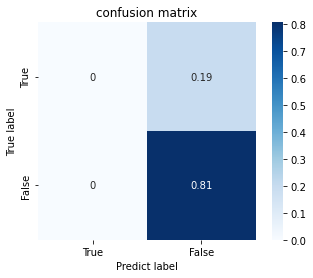

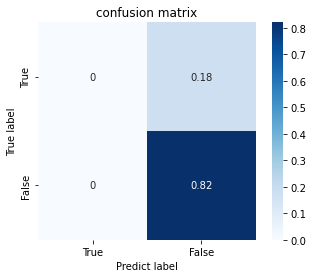

In [6]:
# trainのベースライン
y_train_base = pd.Series([False for i in range(y_train.shape[0])], index=y_train.index)
display(y_train.value_counts())
plot_confusion_matrix(y_train, y_train_base)
# testのベースライン（本命）
y_test_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
plot_confusion_matrix(y_test, y_test_base)

# SMOTEによるオーバーサンプリング
SMOTEと呼ばれる手法によって、不均衡を低減する  
どのようにオーバーサンプリングするのか要確認

In [7]:
sm = SMOTE(sampling_strategy="minority", random_state=SEED)
X_training, X_val, y_training, y_val = train_test_split(X_train, y_train)
X_resampled, y_resampled = sm.fit_resample(X_training, y_training)
y_resampled.value_counts()

False    713
True     713
Name: target_OS_5years, dtype: int64

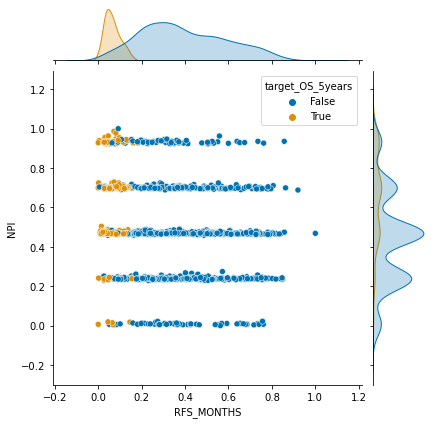

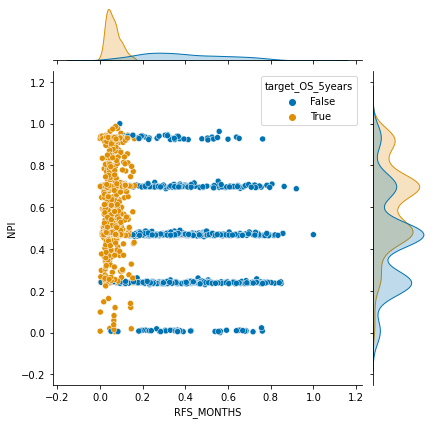

'\n# 決定木の分類例表示（2変数の分類）\nclf = DecisionTreeClassifier()\nsns_separator_plot(\n    clf=clf,\n    x_columns=plot_columns,\n    y_column="target_OS_5years",\n    data=df_tmp,\n    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR\n    + "/sample_SMOTE.png",\n)\n'

In [14]:
plot_columns = ["RFS_MONTHS", "NPI"]
df_tmp = pd.merge(X_resampled, y_resampled, left_index=True, right_index=True)

save_path = (
    config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR
    + "/SMOTE_scatter("
    + plot_columns[0]
    + " x "
    + plot_columns[1]
    + ").png"
)

# SMOTE実施前の分布のプロット
sns_join_plot(
    X=X_train,
    y=y_train,
    plot_columns=plot_columns,
    # save_path=save_path,
)
# SMOTE実施後の分布のプロット
sns_join_plot(
    X=X_resampled,
    y=y_resampled,
    plot_columns=plot_columns,
    # save_path=save_path,
)
"""
# 決定木の分類例表示（2変数の分類）
clf = DecisionTreeClassifier()
sns_separator_plot(
    clf=clf,
    x_columns=plot_columns,
    y_column="target_OS_5years",
    data=df_tmp,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR
    + "/sample_SMOTE.png",
)
"""

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

In [9]:
import warnings


def plot_bcm_border(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    plot_columns: list = plot_columns,
    sort_column_name: str = "f1_test",
    over_sampling_class=None,
    normalization: bool = False,
    save_path: str = ".",
):

    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf in tqdm(zip(bcm_names, classifiers)):  # 指定した複数の分類機を順番に呼び出す
        # init
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
        if normalization:
            # 正規化
            int_columns = [
                # patient
                "LYMPH_NODES_EXAMINED_POSITIVE",
            ]

            float_columns = [
                # patient
                "NPI",
                "AGE_AT_DIAGNOSIS",
                # sample
                "TUMOR_SIZE",
                "TMB_NONSYNONYMOUS",
            ]

            mm = MinMaxScaler()
            mm.fit(X_train[convert_clinical_columns])
            X_train[convert_clinical_columns] = pd.DataFrame(
                mm.transform(X_train[convert_clinical_columns]),
                index=X_train[convert_clinical_columns].index,
                columns=convert_clinical_columns,
            )
            X_test[convert_clinical_columns] = pd.DataFrame(
                mm.transform(X_test[convert_clinical_columns]),
                index=X_test[convert_clinical_columns].index,
                columns=convert_clinical_columns,
            )
        if over_sampling_class:
            X_train, y_train = over_sampling_class.fit_resample(X_train, y_train)

        # プロット
        print(name)  # モデル名
        make_dir(save_path)
        sns_separator_plot(
            clf=clf,
            x_columns=plot_columns,
            y_column="target_OS_5years",
            data=pd.merge(X_train, y_train, left_index=True, right_index=True),
            save_path=save_path + "/" + name + ".png",
        )
    warnings.filterwarnings("always")

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_18290/1884061025.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


In [10]:
convert_columns = [
    "LYMPH_NODES_EXAMINED_POSITIVE",
    "RFS_MONTHS",
    "NPI",
    "AGE_AT_DIAGNOSIS",
    "TUMOR_SIZE",
    "TMB_NONSYNONYMOUS",
]

# 2値分類機の性能比較（パラメータ：デフォルト）
display(
    compare_bcms(X=X_train, y=y_train, bcm_names=bcm_names, classifiers=classifiers)
)
display(
    compare_bcms(
        X=X_train,
        y=y_train,
        bcm_names=bcm_names,
        classifiers=classifiers,
        standardization=True,
        converted_columns=convert_columns,
    )
)
display(
    compare_bcms(
        X=X_train,
        y=y_train,
        bcm_names=bcm_names,
        classifiers=classifiers,
        normalization=True,
        converted_columns=convert_columns,
    )
)

display(
    compare_bcms(
        X=X_train,
        y=y_train,
        bcm_names=bcm_names,
        classifiers=classifiers,
        over_sampling_class=SMOTE(sampling_strategy="minority", random_state=SEED),
    )
)
display(
    compare_bcms(
        X=X_train,
        y=y_train,
        bcm_names=bcm_names,
        classifiers=classifiers,
        standardization=True,
        converted_columns=convert_columns,
        over_sampling_class=SMOTE(sampling_strategy="minority", random_state=SEED),
    )
)
display(
    compare_bcms(
        X=X_train,
        y=y_train,
        bcm_names=bcm_names,
        classifiers=classifiers,
        normalization=True,
        converted_columns=convert_columns,
        over_sampling_class=SMOTE(sampling_strategy="minority", random_state=SEED),
    )
)

11it [00:05,  2.08it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.930263,0.930088,0.837235,0.833547
Random Forest,1.000000,0.934326,1.000000,0.821786
Polynomial SVM,0.918001,0.918288,0.820570,0.821431
Linear SVM,0.951138,0.930074,0.876498,0.819466
Logistic Regression,0.945053,0.925880,0.860261,0.809212
Nearest Neighbors,0.943835,0.923316,0.863099,0.808642
AdaBoost,0.971544,0.921671,0.928835,0.800706
Decision Tree,1.000000,0.909842,1.000000,0.767097
Sigmoid SVM,0.909295,0.911530,0.760154,0.761342


11it [00:03,  3.15it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Polynomial SVM,0.960591,0.933414,0.898521,0.827333
Linear SVM,0.950295,0.932588,0.874874,0.826183
Random Forest,1.000000,0.933485,1.000000,0.819599
Logistic Regression,0.946832,0.928401,0.864958,0.816053
AdaBoost,0.971544,0.921671,0.928835,0.800706
RBF SVM,0.952074,0.920788,0.876765,0.795056
Decision Tree,1.000000,0.909835,1.000000,0.766248
Sigmoid SVM,0.906674,0.909002,0.750807,0.752892
Naive Bayes,0.853597,0.847486,0.722895,0.711688


11it [00:03,  2.91it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,1.000000,0.933485,1.000000,0.819464
AdaBoost,0.971544,0.921671,0.928835,0.800706
Linear SVM,0.932697,0.917455,0.828725,0.782293
Decision Tree,1.000000,0.908987,1.000000,0.763500
Logistic Regression,0.928578,0.912377,0.810921,0.759372
Naive Bayes,0.848542,0.844111,0.716790,0.707499
Polynomial SVM,0.921277,0.893014,0.779934,0.686367
Quadratic Discriminant Analysis,0.806518,0.805334,0.662175,0.658440
RBF SVM,0.894318,0.882894,0.682916,0.632739


11it [00:08,  1.29it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,1.000000,0.935145,1.000000,0.835595
RBF SVM,0.948104,0.918288,0.950359,0.823670
Logistic Regression,0.963561,0.928393,0.963963,0.822275
Linear SVM,0.966641,0.928372,0.966866,0.819961
Nearest Neighbors,0.958564,0.919100,0.960180,0.818779
Polynomial SVM,0.946478,0.914065,0.949024,0.816875
AdaBoost,0.972396,0.919143,0.972741,0.806672
Decision Tree,1.000000,0.915760,1.000000,0.785632
Quadratic Discriminant Analysis,0.916677,0.854294,0.922393,0.708532


11it [00:06,  1.67it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,1.000000,0.930936,1.000000,0.829982
Linear SVM,0.965767,0.930067,0.966206,0.828316
Logistic Regression,0.961120,0.924177,0.961767,0.817656
AdaBoost,0.969957,0.918309,0.970484,0.808225
Polynomial SVM,0.974024,0.914870,0.974444,0.798378
RBF SVM,0.966463,0.909835,0.967325,0.792657
Decision Tree,1.000000,0.914079,1.000000,0.783592
Sigmoid SVM,0.908960,0.873622,0.912186,0.730719
Naive Bayes,0.912360,0.859308,0.915385,0.684563


11it [00:07,  1.38it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,1.000000,0.938506,1.000000,0.847546
AdaBoost,0.969722,0.925053,0.970272,0.824311
Decision Tree,1.000000,0.921649,1.000000,0.809428
Linear SVM,0.956878,0.914029,0.957958,0.797963
Logistic Regression,0.949965,0.900563,0.951357,0.768904
Polynomial SVM,0.956473,0.887936,0.957822,0.743965
RBF SVM,0.936360,0.862648,0.939640,0.711012
Naive Bayes,0.915908,0.860996,0.920377,0.708820
Quadratic Discriminant Analysis,0.887317,0.847557,0.885768,0.637388


デフォルト値のままではf1スコアが出ない  
→全て負事例（0: 5年後も生存）で予測しているケースが多い（多少は正事例（1: 5年以内に死亡）としているケースもあるが）

2022/06/24.  
▷ 特徴量への処理を変更した（nullの少ないデータの削除、nullの多い特徴量の削除）ら精度が向上した

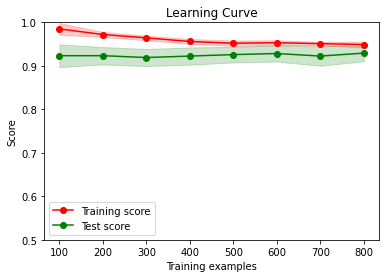

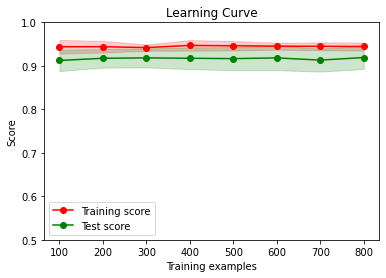

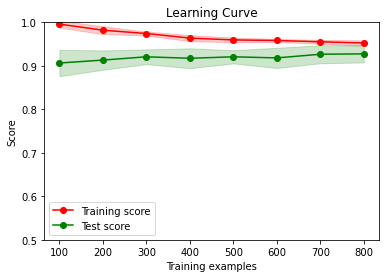

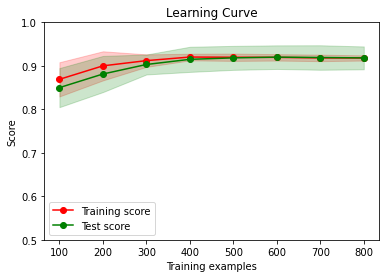

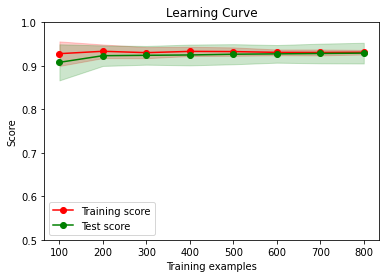

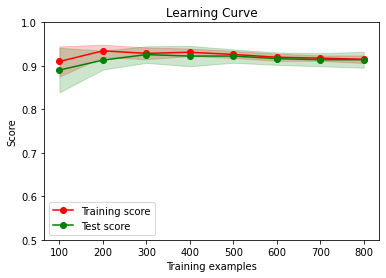

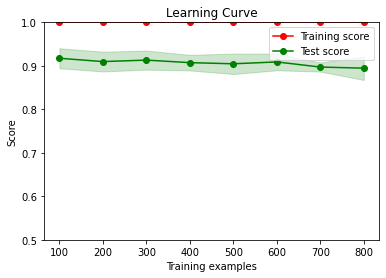

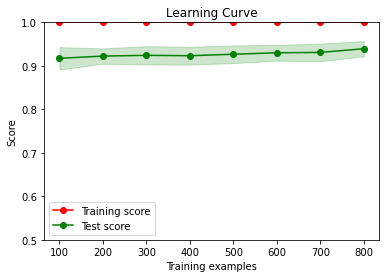

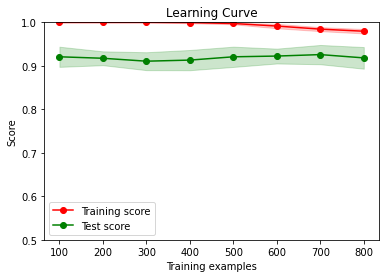

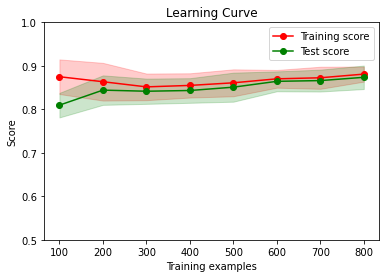

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/

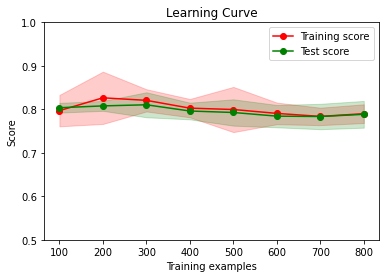

In [11]:
# chi2にて特徴量選択したデータを元に、各モデルでの学習曲線を可視化
# 正規化したほうが全体的に精度が高かったので、そちらを使用
for estimator in classifiers:
    plot_learning_curve(
        X_train,
        y_train,
        estimator,
        cv=10,
        train_sizes=np.arange(100, int(len(X_train) * 0.75), 100),
    )

In [12]:
rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train, y_train)
pred_tmp = rf.predict(X_test)
show_scores(y_test, pred_tmp)

accuracy:  0.9242424242424242
precision:  0.8153846153846154
recall:  0.7464788732394366
f1 score:  0.7794117647058824


Text(0.5, 1.0, 'feature importances')

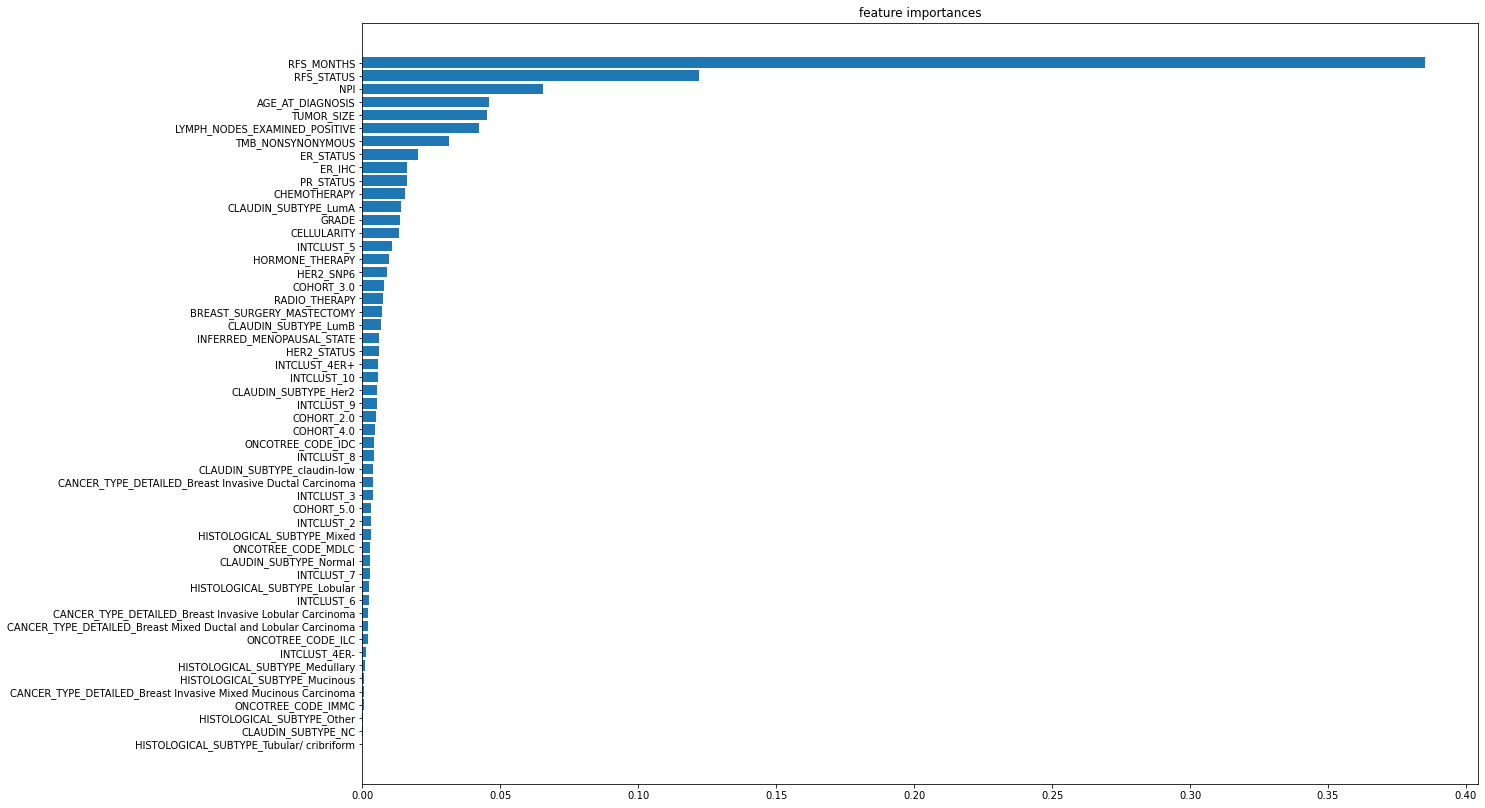

In [13]:
feature_importance = pd.DataFrame(
    {
        "gene_expression": X_test.columns.values,
        "importance": rf.feature_importances_,
    }
)
feature_importance.sort_values(by="importance", ascending=True, inplace=True)

plt.figure(figsize=(20, 14))
plt.barh(feature_importance.gene_expression, feature_importance.importance)
plt.title("feature importances")